In [1]:
import numpy as np
import os
import io
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import hinge_loss
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix,
                    precision_recall_curve, classification_report, precision_score,
                    recall_score, make_scorer)

from sklearn.model_selection import cross_validate, cross_val_predict, GridSearchCV

from pprint import pprint





# Data loading and splitting

In [3]:
X,y = fetch_openml('mnist_784', version=1, return_X_y = True)


In [4]:
X = X.to_numpy()
y = y.to_numpy()

In [5]:
target_names = np.unique(y)

In [6]:
target_names

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [7]:
print("Number of Samples: {0}, datatype, {1}".format(X.shape, X.dtype))
print("Minimum: {0}, Maximum {1}".format(np.min(X), np.max(X)))

Number of Samples: (70000, 784), datatype, float64
Minimum: 0.0, Maximum 255.0


# Scaling X with MinMaxScaler

In [8]:
X = MinMaxScaler().fit_transform(X)

In [9]:
print("Min: {0}, Max: {1}".format(np.min(X), np.max(X)))

Min: 0.0, Max: 1.0


# Visualizing the images

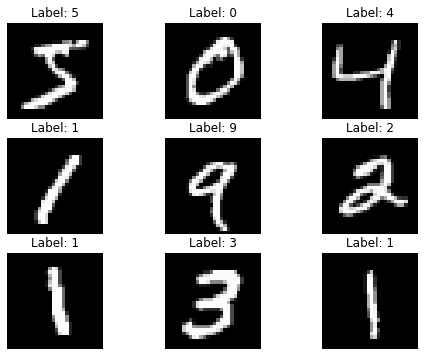

In [10]:
num_images = 9
factor = np.int(np.sqrt(num_images))

fig,ax = plt.subplots(nrows = factor, ncols = factor, figsize = (8,6))

idx_offset = 0 #  takes num_images starting from the index 'idx_offset'

for i in range(factor):
    index = idx_offset + i*(factor)

    for j in range(factor):
        ax[i,j].imshow(X[index+j].reshape(28,28), cmap = 'gray')
        ax[i,j].set_title('Label: {0}'.format(str(y[index+j])))
        ax[i,j].set_axis_off()

# Train test split

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Count plotting to check if the data is imbalanced or not

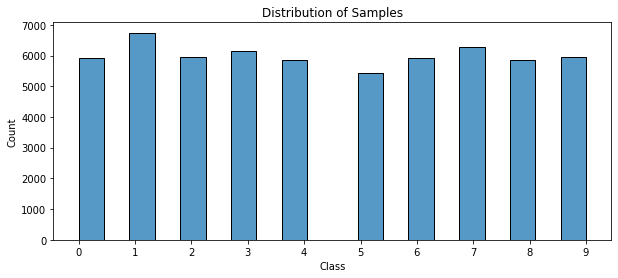

In [12]:
plt.figure(figsize = (10,4))
sns.histplot(data = np.int8(y_train), binwidth = 0.45, bins=11)
plt.xticks(ticks = [0,1,2,3,4,5,6,7,8,9], labels = [0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Class')
plt.title("Distribution of Samples")
plt.show()

In [13]:
y_train_0 = np.where(y_train == '0' , 1, -1)
y_test_0 = np.where(y_test == '0' ,1,-1)

# Dummy classifier

In [14]:
strategies = ['most_frequent', 'stratified', 'uniform', 'constant']
const = 1
test_score = []
for s in strategies:
    if s == 'constant':
        dclf = DummyClassifier(strategy = s, random_state=0, constant=1)
    else:
        dclf = DummyClassifier(strategy = s, random_state = 0)
        dclf.fit(X_train, y_train_0)
        score = dclf.score(X_test, y_test_0)
        test_score.append(score)

In [15]:
dclf = DummyClassifier(strategy = 'most_frequent', random_state = 0)
dclf.fit(X_train, y_train_0)
print(dclf.score(X_train, y_train_0))
print(dclf.score(X_test, y_test_0))

0.9012833333333333
0.902


# Perceptron model

In [16]:
from sklearn.linear_model import Perceptron
bin_clf = Perceptron(max_iter = 100, random_state=42)


In [17]:
bin_clf.fit(X_train, y_train_0)
print("Dimension of Weights: {0}".format(bin_clf.coef_.shape))
print("Bias: {0}".format(bin_clf.intercept_))
print("The Local function: {0}".format(bin_clf.loss_function_))

Dimension of Weights: (1, 784)
Bias: [-96.]
The Local function: <sklearn.linear_model._sgd_fast.Hinge object at 0x00000210B8CF90D0>


In [18]:
y_hat_train_0 = bin_clf.predict(X_train)
print('Training Accuracy: ', bin_clf.score(X_test, y_test_0))

Training Accuracy:  0.9907


### Displaying predictions 

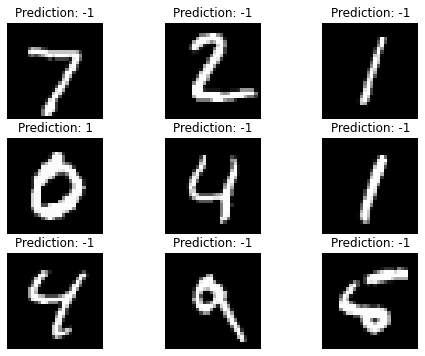

In [19]:
y_hat_test_0 = bin_clf.predict(X_test)
num_images = 9
factor = np.int(np.sqrt(num_images))
fig,ax = plt.subplots(nrows = factor, ncols = factor, figsize = (8,6))

idx_offset = 0
for i in range(factor):
    index = idx_offset +i * (factor)
    for j in range(factor):
        ax[i, j].imshow(X_test[index+j].reshape(28,28), cmap = 'gray')
        ax[i,j].set_title('Prediction: {0}'.format(str(y_hat_test_0[index+j])))
        ax[i,j].set_axis_off()

In [20]:
indx_0 = np.where(y_test_0 == 1)

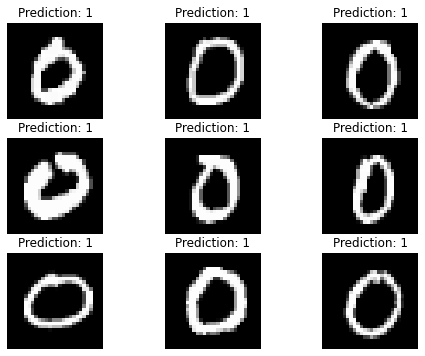

In [21]:
zeroImgs = X_test[indx_0[0]]
zeroLabls = y_hat_test_0[indx_0[0]]
num_images = 9

factor = np.int(np.sqrt(num_images))

fig, ax = plt.subplots(nrows = factor, ncols = factor, figsize = (8,6))

idx_offset = 0
for i in range(factor):
    index = idx_offset + i*(factor)
    for j in range(factor):
        ax[i,j].imshow(zeroImgs[index + j].reshape(28,28), cmap = 'gray')
        ax[i,j].set_title('Prediction: {0}'.format(str(zeroLabls[index+j])))
        ax[i,j].set_axis_off()

In [22]:
num_misclassified = np.count_nonzero(zeroLabls == -1)
num_correctpred = len(zeroLabls) - num_misclassified
accuracy = num_correctpred/len(zeroLabls)
print(accuracy)

0.9581632653061225


### Confusion matrix

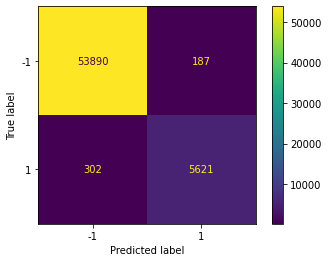

In [23]:
y_hat_train_0 = bin_clf.predict(X_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format = '.5g')

## Precision and Recall

In [24]:
cf_matrix = cm_display.confusion_matrix
tn = cf_matrix[0,0]
fn = cf_matrix[1,0]
fp = cf_matrix[0,1]
tp = cf_matrix[1,1]

In [25]:
precision = tp/(tp+fp)
print('Precision: ', precision)

recall = tp/ (tp+ fn)
print('Recall', recall)

accuracy = (tn+tp) / (tn + tp+fn+fp)
print("Accuracy: ", accuracy)

Precision:  0.9678030303030303
Recall 0.9490123248353874
Accuracy:  0.99185


### cross validation

In [26]:
bin_clf = Perceptron(max_iter = 100, random_state=24)
scores = cross_validate(bin_clf, X_train, y_train, cv=5,
                scoring = ['precision', 'recall', 'f1'],
                return_estimator = True)
pprint(scores)

{'estimator': [Perceptron(max_iter=100, random_state=24),
               Perceptron(max_iter=100, random_state=24),
               Perceptron(max_iter=100, random_state=24),
               Perceptron(max_iter=100, random_state=24),
               Perceptron(max_iter=100, random_state=24)],
 'fit_time': array([7.55159783, 9.18870521, 9.21875453, 9.15272021, 9.48948312]),
 'score_time': array([0.15453243, 0.05500126, 0.05800033, 0.05000305, 0.05100274]),
 'test_f1': array([nan, nan, nan, nan, nan]),
 'test_precision': array([nan, nan, nan, nan, nan]),
 'test_recall': array([nan, nan, nan, nan, nan])}


bin_clf = scores['estimator'][0]
y_hat_test_0 = bin_clf.predict(X_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, y_hat_test_0, values_format = '0.5g')

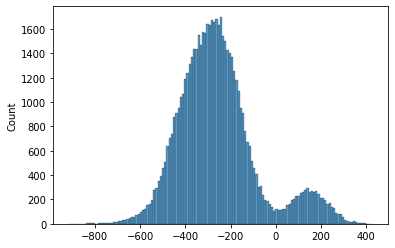

In [27]:
bin_clf = Perceptron(random_state=42)
bin_clf.fit(X_train, y_train_0)
y_scores = bin_clf.decision_function(X_train)
sns.histplot(np.sort(y_scores))
plt.show()

### Precision recall thresholds

In [28]:
precisions, recalls, thresholds = precision_recall_curve(y_train_0, y_scores, pos_label=1)

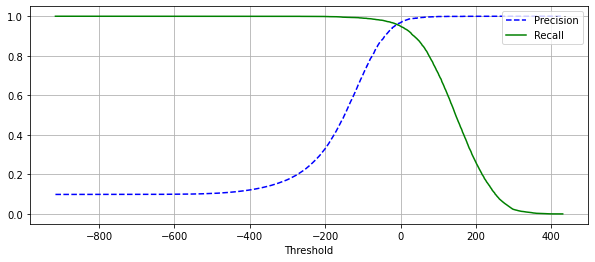

In [29]:
plt.figure(figsize = (10,4))
plt.plot(thresholds, precisions[:-1], 'b--', label = "Precision")
plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
plt.xlabel("Threshold")
plt.grid(True)
plt.legend(loc = 'upper right')
plt.show()

# ROC Curve


In [30]:
from sklearn.metrics import roc_curve

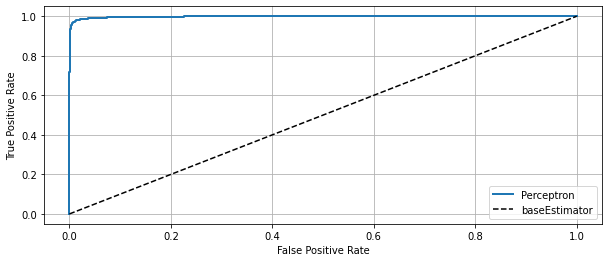

In [31]:
fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)
plt.figure(figsize = (10,4))
plt.plot(fpr,tpr, linewidth = 2, label = 'Perceptron')
plt.plot([0,1], [0,1], 'k--', label = 'baseEstimator')
plt.xlabel('False Positive Rate')
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend()
plt.show()

# Multi class label prediction

In [32]:
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import LabelBinarizer

In [33]:
clf = Perceptron(random_state=42)

y_train_ovr = LabelBinarizer().fit_transform(y_train)
for i in range(10):
    print( "{0}: {1}".format(y_train[i], y_train_ovr[i]))

5: [0 0 0 0 0 1 0 0 0 0]
0: [1 0 0 0 0 0 0 0 0 0]
4: [0 0 0 0 1 0 0 0 0 0]
1: [0 1 0 0 0 0 0 0 0 0]
9: [0 0 0 0 0 0 0 0 0 1]
2: [0 0 1 0 0 0 0 0 0 0]
1: [0 1 0 0 0 0 0 0 0 0]
3: [0 0 0 1 0 0 0 0 0 0]
1: [0 1 0 0 0 0 0 0 0 0]
4: [0 0 0 0 1 0 0 0 0 0]


In [34]:
clf.fit(X_train, y_train)

Perceptron(random_state=42)

In [35]:
print("Shape of Weight matrix: {0} and bias vector: {1}".format(clf.coef_.shape,
                                                               clf.intercept_.shape))

Shape of Weight matrix: (10, 784) and bias vector: (10,)


# Importent

In [36]:
scores = clf.decision_function(X_train[6].reshape(1,-1))
print(scores)
print('The predicted class: ', np.argmax(scores))

[[-654.27223376  151.90594387 -120.04027682  -62.80378316 -200.08838139
  -132.59869281  -97.16593618 -188.9330719   -64.85310265 -173.42928105]]
The predicted class:  1


In [37]:
print("predicted output: ")
print(clf.predict(X_train[0].reshape(1,-1)))

predicted output: 
['5']


In [38]:
y_hat = clf.predict(X_train)

In [39]:
print(classification_report(y_train, y_hat))

              precision    recall  f1-score   support

           0       0.98      0.93      0.96      5923
           1       0.95      0.96      0.95      6742
           2       0.86      0.90      0.88      5958
           3       0.97      0.67      0.80      6131
           4       0.93      0.91      0.92      5842
           5       0.78      0.87      0.82      5421
           6       0.89      0.97      0.93      5918
           7       0.96      0.86      0.91      6265
           8       0.75      0.90      0.82      5851
           9       0.84      0.87      0.85      5949

    accuracy                           0.89     60000
   macro avg       0.89      0.88      0.88     60000
weighted avg       0.89      0.89      0.88     60000



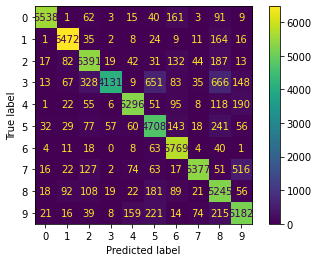

In [40]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_train, y_hat, values_format = '.5g')

# Making a Pipeline

In [41]:
estimators = [('std_scaler', MinMaxScaler()), ('bin_clf', Perceptron())]
pipe = Pipeline(estimators)

In [42]:
pipe.fit(X_train, y_train_0)

Pipeline(steps=[('std_scaler', MinMaxScaler()), ('bin_clf', Perceptron())])

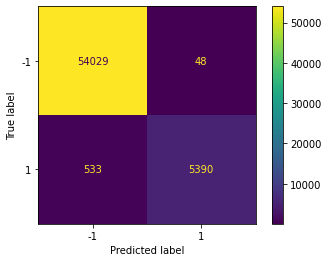

In [43]:
y_hat_train_0 = pipe.predict(X_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0,
                                                    values_format = "0.5g")

# Iteration vs Loss Curve

In [44]:
iterations = 100
bin_clf1 = Perceptron(max_iter = 1000, random_state=42)
Loss_clf1 = []
for i in range(iterations):
    bin_clf1.partial_fit(X_train, y_train_0, classes = np.array([1,-1]))
    y_hat_0 = bin_clf1.decision_function(X_train)
    Loss_clf1.append(hinge_loss(y_train_0, y_hat_0))

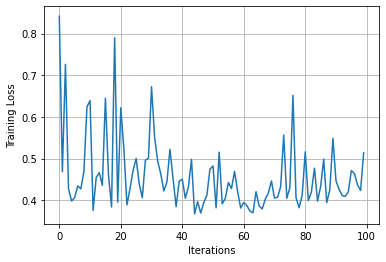

In [45]:
plt.figure()
plt.plot(np.arange(iterations), Loss_clf1)
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.show()

# Ridge classifier

In [52]:
from sklearn.linear_model import RidgeClassifier

In [57]:
from sklearn.pipeline import make_pipeline

In [59]:
estimator = RidgeClassifier(normalize = False, alpha=0)
pipe_ridge = make_pipeline(MinMaxScaler(), estimator)
pipe_ridge.fit(X_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))])

In [60]:
y_hat_0 = pipe_ridge.predict(X_test)
print(classification_report(y_test_0, y_hat_0))

              precision    recall  f1-score   support

          -1       0.99      1.00      0.99      9020
           1       0.96      0.88      0.92       980

    accuracy                           0.98     10000
   macro avg       0.97      0.94      0.96     10000
weighted avg       0.98      0.98      0.98     10000



### Cross validation

In [61]:
cv_bin_ridge_clf = cross_validate(
            pipe_ridge, X_train, y_train_0, cv=5,
            scoring = ['precision', 'recall', 'f1'],
            return_train_score = True,
            return_estimator = True
)

In [62]:
pprint(cv_bin_ridge_clf)

{'estimator': [Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))])],
 'fit_time': array([ 8.52266932, 10.80370212, 10.5983634 , 11.81568217, 14.25308824]),
 'score_time': array([0.0860064 , 0.1230092 , 0.08800697, 0.15101337, 0.0880065 ]),
 'test_f1': array([0.91519435, 0.9047619 , 0.9132948 , 0.90222222, 0.9065713 ]),
 'test_preci

In [63]:
best_estimator_id = np.argmax(cv_bin_ridge_clf['train_f1']); best_estimator_id

3

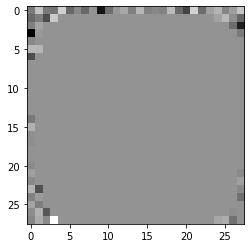

In [68]:
plt.imshow((pipe_ridge[1].coef_).reshape(28,28), cmap='gray')

# Naive Bayes classifier

In [69]:
from sklearn.datasets import fetch_20newsgroups

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import make_pipeline

from sklearn.metrics import ConfusionMatrixDisplay


In [72]:
data = fetch_20newsgroups()

In [73]:
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [75]:
categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics']

train = fetch_20newsgroups(subset='train', categories = categories)
test = fetch_20newsgroups(subset='test', categories = categories)

In [76]:
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



In [77]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [78]:
model.fit(train.data, train.target)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

### Model evaluation

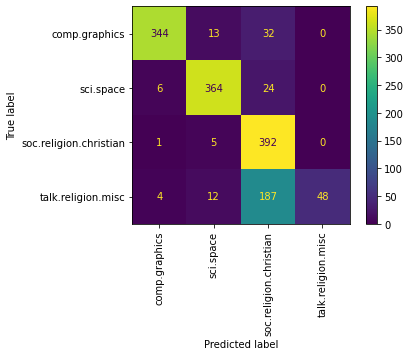

In [79]:
ConfusionMatrixDisplay.from_estimator(
    model, test.data, test.target, display_labels = test.target_names,
    xticks_rotation = 'vertical'
)

In [81]:
np.unique(train.target)

array([0, 1, 2, 3], dtype=int64)

In [87]:
model.classes_

array([0, 1, 2, 3], dtype=int64)

In [91]:
np.unique(data.target)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [ ]:
data.